In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
delta = 0.04        # discount rate (per year)
C = 3661.0          # replantation cost (€/ha)
xi = 0.8            # coinsurance rate
P_ins = 20.0        # insurance premium (€/ha per year)
lam = 7.1e-4        # baseline annual fire hazard (per year)

# Growth function parameters
Vmax, Tmax, beta = 25_000.0, 40.0, 2.0

# Grid of candidate rotation ages for optimization
T_grid = np.arange(10, 61, 1)  # T = 10..60 years (will allow T* to vary endogenously)
thetas = [0.4, 0.5, 0.6, 0.7, 0.8]
dt = 0.05                      # time discretization step (years)

# CRRA preferences
gamma = 1.0
W0 = 100_000.0

# CORE MODEL COMPONENTS

def V(t):
    t = np.maximum(t, 0.0)
    return Vmax * (t / Tmax)**beta

def Ee_minus_delta_tau(T, lam):
    # E[e^{-δτ}] where τ is fire arrival time (Poisson)
    expr = np.exp(-(delta + lam) * T)
    return (lam/(delta+lam))*(1.0 - expr) + expr

def pv_premium_continuous(t, Pflow, lam):
    # present value of continuous premium flow until min(fire, harvest)
    if Pflow <= 0.0:
        return 0.0 if np.isscalar(t) else np.zeros_like(t, float)
    return (Pflow/(delta+lam))*(1.0 - np.exp(-(delta+lam)*t))


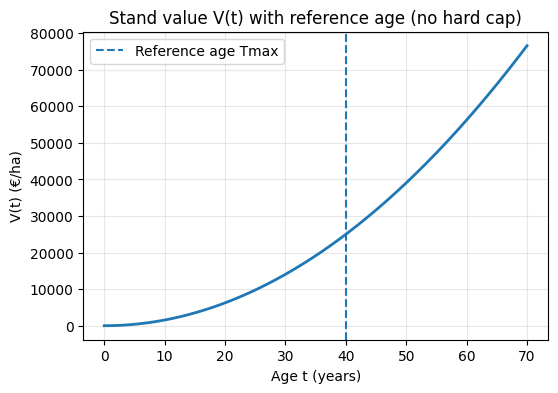

In [106]:
# Stand growth and value function V(t)
t_plot = np.linspace(0, 70, 701)
plt.figure(figsize=(6,4))
plt.plot(t_plot, V(t_plot), linewidth=2)
plt.axvline(Tmax, linestyle="--", label="Reference age Tmax")
plt.title("Stand value V(t) with reference age (no hard cap)")
plt.xlabel("Age t (years)")
plt.ylabel("V(t) (€/ha)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


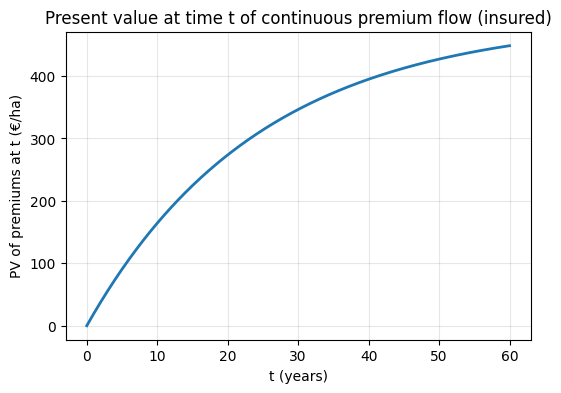

In [107]:
# Present value of the continuous insurance premium over time
t_plot = np.linspace(0, 60, 601)
pv_p = pv_premium_continuous(t_plot, P_ins, lam)  

plt.figure(figsize=(6,4))
plt.plot(t_plot, pv_p, linewidth=2)
plt.title("Present value at time t of continuous premium flow (insured)")
plt.xlabel("t (years)"); plt.ylabel("PV of premiums at t (€/ha)")
plt.grid(True, alpha=0.3)
plt.show()

In [108]:
#Check E[e^{-δ τ}] validation of the survival-discount factor
T_test = 40.0
closed = Ee_minus_delta_tau(T_test, lam)

t = np.arange(0.0, T_test, 0.001)
num_int = np.trapz(np.exp(-delta*t) * lam * np.exp(-lam*t), t) + np.exp(-(delta+lam)*T_test)

print(f"E[e^(-δ τ)] fermé   = {closed:.8f}")
print(f"E[e^(-δ τ)] numérique ≈ {num_int:.8f}")

E[e^(-δ τ)] fermé   = 0.21026118
E[e^(-δ τ)] numérique ≈ 0.21026104


/var/folders/1j/f7xsvs8x6n307bvzysrkndkm0000gn/T/ipykernel_58409/756287871.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num_int = np.trapz(np.exp(-delta*t) * lam * np.exp(-lam*t), t) + np.exp(-(delta+lam)*T_test)


In [109]:
# Expected utility components under fire risk 
def a0_coef(T, lam):
    expr = np.exp(-(delta + lam) * T)
    return (lam / (delta + lam)) * (1.0 - expr)

def a1_coef(T, lam):
    return np.exp(-(delta + lam) * T)

def numerator_crra_log(T, theta, lam, insured):
    # Loss in case of fire at time t < T
    t = np.arange(0.0, T, dt)
    dens = lam * np.exp(-lam * t)       # f_tau(t)
    disc = np.exp(-delta * t)           # e^{-δ t}
    Vt   = V(t)

    if insured:
        # salvage + indemnity - replantation
        Y_fire = (1.0 - theta) * Vt + xi * theta * Vt - C
    else:
        # salvage - replantation
        Y_fire = (1.0 - theta) * Vt - C

    eps = 1e-12
    util_fire = np.log(np.maximum(1.0 + Y_fire / W0, eps))
    term_fire = 0.0 if t.size < 2 else np.trapz(disc * util_fire * dens, t)

    # If no fire before T → harvest at T
    V_T = V(T)
    Y_T = V_T - C
    util_T = np.log(np.maximum(1.0 + Y_T / W0, eps))
    term_no_fire = np.exp(-(delta + lam) * T) * util_T

    # Utility of the premium flow
    if insured and P_ins > 0:
        u_minusP = np.log(np.maximum(1.0 - P_ins / W0, eps))
        prem_util = a0_coef(T, lam) * u_minusP + (a1_coef(T, lam) / delta) * u_minusP
    else:
        prem_util = 0.0

    return term_fire + term_no_fire + prem_util


In [110]:
# Stochastic Faustmann value and Certainty Equivalent (test on one scenario)

def JF_crra_log(T, theta, lam, insured):
    num = numerator_crra_log(T, theta, lam, insured)
    den = 1.0 - Ee_minus_delta_tau(T, lam)
    return num / den                # in utility units

def CE_from_JF(JF_vals):
    # log-utility: CE = W0*(exp(JF) - 1)
    return W0 * (np.exp(JF_vals) - 1.0)

# Test on a single T value: insured vs uninsured scenario, theta=0.6
T0 = 40.0; theta0 = 0.6
JU = JF_crra_log(T0, theta0, lam, insured=False)
JI = JF_crra_log(T0, theta0, lam, insured=True)
print("JF (uninsured, utility units) =", JU)
print("JF (insured  , utility units) =", JI)
print("CE (uninsured, €/ha) =", CE_from_JF(JU))
print("CE (insured  , €/ha) =", CE_from_JF(JI))

JF (uninsured, utility units) = 0.047777641873207384
JF (insured  , utility units) = 0.04695988981866101
CE (uninsured, €/ha) = 4893.738963808847
CE (insured  , €/ha) = 4807.996955891802


/var/folders/1j/f7xsvs8x6n307bvzysrkndkm0000gn/T/ipykernel_58409/1079508358.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  term_fire = 0.0 if t.size < 2 else np.trapz(disc * util_fire * dens, t)


T*_U=42.0, T*_I=43.0, ΔT=1.0 ans
CE*_U=4908.1 €/ha, CE*_I=4841.7 €/ha, ΔCE=-66.3 €/ha


/var/folders/1j/f7xsvs8x6n307bvzysrkndkm0000gn/T/ipykernel_58409/1079508358.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  term_fire = 0.0 if t.size < 2 else np.trapz(disc * util_fire * dens, t)


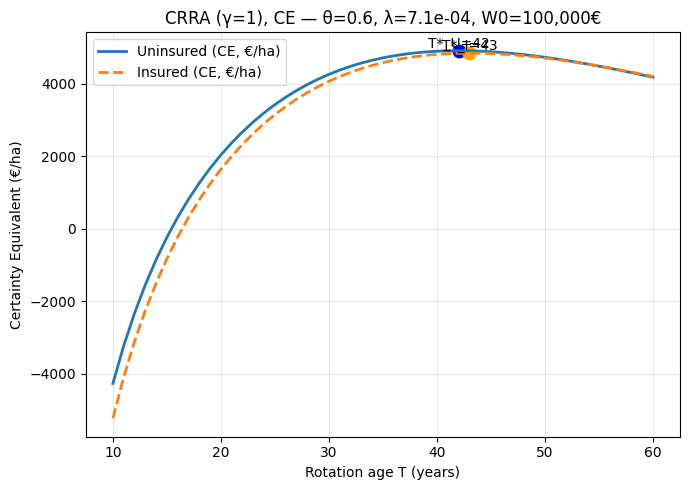

In [111]:
# CE(T) comparison with and without insurance (θ = 0.6)

theta = 0.6

JU = np.array([JF_crra_log(float(T), theta, lam, False) for T in T_grid])
JI = np.array([JF_crra_log(float(T), theta, lam, True ) for T in T_grid])

CEU = CE_from_JF(JU)
CEI = CE_from_JF(JI)

iU = int(np.argmax(CEU))
iI = int(np.argmax(CEI))

T_U = float(T_grid[iU])
T_I = float(T_grid[iI])

print(f"T*_U={T_U:.1f}, T*_I={T_I:.1f}, ΔT={T_I - T_U:.1f} ans")
print(f"CE*_U={CEU[iU]:.1f} €/ha, CE*_I={CEI[iI]:.1f} €/ha, ΔCE={CEI[iI] - CEU[iU]:.1f} €/ha")

plt.figure(figsize=(7,5))
plt.plot(T_grid, CEU, label="Uninsured (CE, €/ha)", linewidth=2)
plt.plot(T_grid, CEI, "--", label="Insured (CE, €/ha)", linewidth=2)

plt.scatter([T_U], [CEU[iU]], s=80, color="blue")
plt.scatter([T_I], [CEI[iI]], s=80, color="orange")

plt.text(T_U, CEU[iU], f"T*_U={T_U:.0f}", ha="center", va="bottom")
plt.text(T_I, CEI[iI], f"T*_I={T_I:.0f}", ha="center", va="bottom")

plt.title(f"CRRA (γ=1), CE — θ={theta}, λ={lam:.1e}, W0={W0:,.0f}€")
plt.xlabel("Rotation age T (years)")
plt.ylabel("Certainty Equivalent (€/ha)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [112]:
# Sensitivity analysis: wealth levels {15k, 50k, 100k} and fire risk baseline vs 3%/year

def solve_T_star_given(W0_val, lam_val, theta, T_grid):
    global W0
    W0_backup = W0
    W0 = float(W0_val)

    JU = np.array([JF_crra_log(float(T), theta, lam_val, False) for T in T_grid])
    JI = np.array([JF_crra_log(float(T), theta, lam_val, True ) for T in T_grid])
    CEU, CEI = CE_from_JF(JU), CE_from_JF(JI)

    iU = int(np.argmax(CEU)); iI = int(np.argmax(CEI))
    out = {
        "W0": W0_val,
        "lam": lam_val,
        "T*_U": float(T_grid[iU]),
        "CE*_U": float(CEU[iU]),
        "T*_I": float(T_grid[iI]),
        "CE*_I": float(CEI[iI]),
        "ΔT": float(T_grid[iI] - T_grid[iU]),
        "ΔCE": float(CEI[iI] - CEU[iU]),
    }
    W0 = W0_backup
    return out

theta_sens = 0.6   
W0_list   = [15_000, 50_000, 100_000]
lam_base  = lam                      # current fire risk baseline (EFFIS)
lam_3pct  = -np.log(1.0 - 0.03)      # fire probability 3%/year

results = []
for W0_val in W0_list:
    results.append(solve_T_star_given(W0_val, lam_base, theta_sens, T_grid))
    results.append(solve_T_star_given(W0_val, lam_3pct, theta_sens, T_grid))

# Print
print("Sensitivity summary (θ = {:.1f})".format(theta_sens))
print("Columns: W0, λ,  T*_U, CE*_U,  T*_I, CE*_I,  ΔT, ΔCE")
for r in results:
    print(f"W0={r['W0']:>6.0f}€, λ={r['lam']:.5f}  | "
          f"T*_U={r['T*_U']:>4.1f}, CE*_U={r['CE*_U']:>7.1f}€  ||  "
          f"T*_I={r['T*_I']:>4.1f}, CE*_I={r['CE*_I']:>7.1f}€  ||  "
          f"ΔT={r['ΔT']:>+4.1f}, ΔCE={r['ΔCE']:>+7.1f}€")

Sensitivity summary (θ = 0.6)
Columns: W0, λ,  T*_U, CE*_U,  T*_I, CE*_I,  ΔT, ΔCE
W0= 15000€, λ=0.00071  | T*_U=34.0, CE*_U= 3807.9€  ||  T*_I=35.0, CE*_I= 3640.1€  ||  ΔT=+1.0, ΔCE= -167.8€
W0= 15000€, λ=0.03046  | T*_U=32.0, CE*_U= -344.3€  ||  T*_I=38.0, CE*_I=  605.0€  ||  ΔT=+6.0, ΔCE= +949.3€
W0= 50000€, λ=0.00071  | T*_U=39.0, CE*_U= 4586.0€  ||  T*_I=40.0, CE*_I= 4493.9€  ||  ΔT=+1.0, ΔCE=  -92.1€
W0= 50000€, λ=0.03046  | T*_U=35.0, CE*_U=  284.7€  ||  T*_I=43.0, CE*_I= 1410.1€  ||  ΔT=+8.0, ΔCE=+1125.4€
W0=100000€, λ=0.00071  | T*_U=42.0, CE*_U= 4908.1€  ||  T*_I=43.0, CE*_I= 4841.7€  ||  ΔT=+1.0, ΔCE=  -66.3€
W0=100000€, λ=0.03046  | T*_U=36.0, CE*_U=  471.0€  ||  T*_I=45.0, CE*_I= 1675.3€  ||  ΔT=+9.0, ΔCE=+1204.3€


/var/folders/1j/f7xsvs8x6n307bvzysrkndkm0000gn/T/ipykernel_58409/1079508358.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  term_fire = 0.0 if t.size < 2 else np.trapz(disc * util_fire * dens, t)


[λ=3%/an]  W0=15,000€  ->  T*_U=32.0, T*_I=38.0, ΔT=6.0 | CE*_U=-344.3€, CE*_I=605.0€, ΔCE=949.3€


/var/folders/1j/f7xsvs8x6n307bvzysrkndkm0000gn/T/ipykernel_58409/1079508358.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  term_fire = 0.0 if t.size < 2 else np.trapz(disc * util_fire * dens, t)


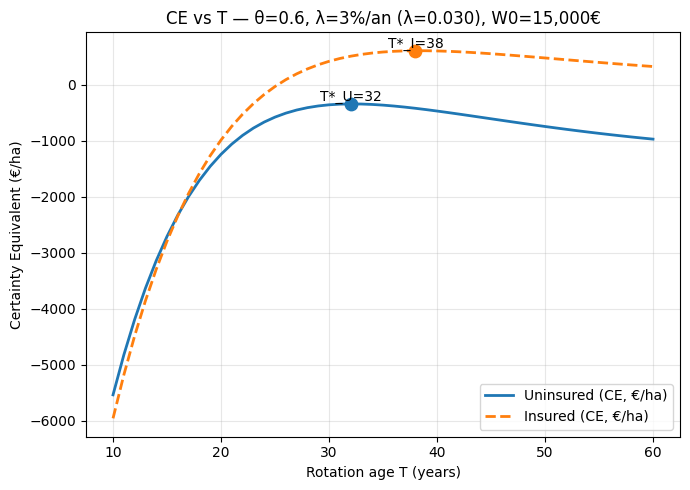

[λ=3%/an]  W0=50,000€  ->  T*_U=35.0, T*_I=43.0, ΔT=8.0 | CE*_U=284.7€, CE*_I=1410.1€, ΔCE=1125.4€


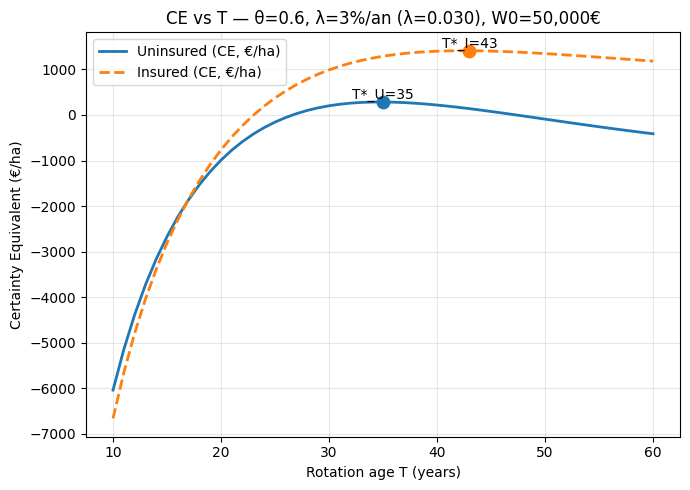

[λ=3%/an]  W0=100,000€  ->  T*_U=36.0, T*_I=45.0, ΔT=9.0 | CE*_U=471.0€, CE*_I=1675.3€, ΔCE=1204.3€


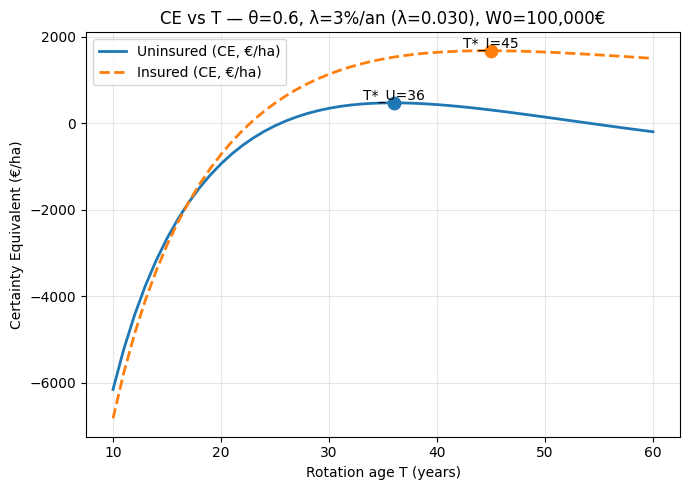

In [113]:
# CE(T) under λ = 3%/an, for W0 ∈ {15k, 50k, 100k}

lam_s = lam_3pct      # high fire risk scenario (3% per year)
for W0_val in W0_list:
    # temporarily update W0 locally (global state dependency)
    W0_backup = W0; W0 = float(W0_val)

    JU = np.array([JF_crra_log(float(T), theta_sens, lam_s, False) for T in T_grid])
    JI = np.array([JF_crra_log(float(T), theta_sens, lam_s, True ) for T in T_grid])
    CEU, CEI = CE_from_JF(JU), CE_from_JF(JI)
    iU = int(np.argmax(CEU)); iI = int(np.argmax(CEI))
    T_U = float(T_grid[iU]); T_I = float(T_grid[iI])

    print(f"[λ=3%/an]  W0={W0_val:,.0f}€  ->  T*_U={T_U:.1f}, T*_I={T_I:.1f}, "
          f"ΔT={T_I - T_U:.1f} | CE*_U={CEU[iU]:.1f}€, CE*_I={CEI[iI]:.1f}€, ΔCE={CEI[iI]-CEU[iU]:.1f}€")

    plt.figure(figsize=(7,5))
    plt.plot(T_grid, CEU, label="Uninsured (CE, €/ha)", linewidth=2)
    plt.plot(T_grid, CEI, "--", label="Insured (CE, €/ha)", linewidth=2)

    plt.scatter([T_U], [CEU[iU]], s=80)
    plt.scatter([T_I], [CEI[iI]], s=80)

    plt.text(T_U, CEU[iU], f"T*_U={T_U:.0f}", ha="center", va="bottom")
    plt.text(T_I, CEI[iI], f"T*_I={T_I:.0f}", ha="center", va="bottom")

    plt.title(f"CE vs T — θ={theta_sens}, λ=3%/an (λ={lam_s:.3f}), W0={W0_val:,.0f}€")
    plt.xlabel("Rotation age T (years)")
    plt.ylabel("Certainty Equivalent (€/ha)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # restore
    W0 = W0_backup